# Explaining the network's predicitons in terms of connectivity changes
# and feature importance. To run it, one needs to have a final model
# checkpoints saved for every fold and the corresponding testing set.
# Explanations are done by the model trained on a given fold and
# on it's testing data, then merged to create average values.
## The structure of the folder with checkpoints should be:
checkpoints/ <br>
  - fold_0/ <br>
    - checkpoint_name.ckpt <br>
  - fold_1/ <br>
    - checkpoint_name.ckpt <br>
  - ... <br>
  - fold_n <br>
    - checkpoint_name.ckpt <br>  
## The same structure follows for the testing data folder.

In [1]:
import torch
import matplotlib
import torch_geometric
from torch_geometric.loader import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from models import GATv2Lightning
from utils.dataloader_utils import GraphDataset
from torch_geometric.nn import Sequential
from sklearn.utils.class_weight import compute_class_weight
import lightning.pytorch as pl
import os
import json
import networkx as nx
from torchmetrics.classification import MulticlassConfusionMatrix
from sklearn.metrics import balanced_accuracy_score
import seaborn as sns
import matplotlib as mpl
from statistics import mean, stdev


# Visualize confusion matrix from pervious runs

In [ ]:
lookback=3600
heatmap_npy_file = f"../explainability_results/metrics/final_runs_lookback_{lookback}/summary_conf_matrix.npy"
heatmap_save_path = f"../plots/confusion_matrices/heatmap_lookback_{lookback}.pdf"
summary_conf_matrix = np.load(heatmap_npy_file)
class_names = ["preictal", "ictal", "interictal"]
row_sums = summary_conf_matrix.sum(axis=1, keepdims=True)
norm_summary_conf_matrix = summary_conf_matrix / row_sums

# Create custom annotations
annotations = np.empty_like(summary_conf_matrix).astype(str)
nrows, ncols = summary_conf_matrix.shape
for i in range(nrows):
    for j in range(ncols):
        c = int(summary_conf_matrix[i, j])
        p = norm_summary_conf_matrix[i, j] * 100  # Convert to percentage
        annotations[i, j] = f"{c}\n({p:.2f}%)"


# Create the heatmap
display_final = sns.heatmap(
    norm_summary_conf_matrix,
    annot=annotations,
    fmt="",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=False,
    cmap="Blues",
)
plt.savefig(heatmap_save_path, dpi=400)

# Attention explanations

# Visualize the attention weights

In [19]:
def create_graph_from_dict(input_dict, self_loops=False, threshold=0.0):
    """Helper function to create a graph from a dictionary of edges
    and their connection strength. The graph is created using networkx.
    Args:
        input_dict (dict): Dictionary of edges and their connection strength.
        self_loops (bool, optional): Whether to include self loops. Defaults to False.
        threshold (float, optional): Threshold to apply to the connection strength. 
        Defaults to 0.0 (all edges included).
    Returns:
        networkx.Graph: Graph object created from the input dictionary.
    """
    g = nx.Graph()
    nodes = np.arange(18)
    g.add_nodes_from(nodes)
    for edge, value in input_dict.items():
        if value < threshold:
            continue
        # value = (-1)*np.log(value)
        if self_loops:
            g.add_edge(*edge, strength=value)
        else:
            if edge[0] != edge[1]:
                g.add_edge(*edge, strength=value)
    return g

In [20]:
def reverse_dict(d):
    """ Helper function to reverse a dictionary.
    Args:
        d (dict): Dictionary to reverse.
    Returns:
        dict: Reversed dictionary.
    """
    return {v: k for k, v in d.items()}

### Load computed attention weights

In [13]:
lookback = 600
result_dir = f"../explainability_results/attention/final_runs_lookback_{lookback}"
try:
    del sum_masks_att
except NameError:
    print("No sum masks")
try:
    del ictal_masks_att
except NameError:
    print("No ictal masks")
try:
    del interictal_masks_att
except NameError:
    print("No interictal masks")
try:
    del preictal_masks_att
except NameError:
    print("No preictal masks")
for n, fold_folder in enumerate(os.listdir(result_dir)):
    explanation_filenames_att = [os.path.join(result_dir, fold_folder, f) for f in os.listdir(os.path.join(result_dir, fold_folder)) if f.endswith(".json")]
    explanation_filenames_att.sort()
    for explanation_filename in explanation_filenames_att:
        explanation = json.loads(open(explanation_filename).read())
        explanation = {eval(k): v for k, v in explanation.items()}
        keyword = os.path.basename(explanation_filename).split('_')[-1].split('.')[0]
        if keyword == "all":
            if n == 0:
                print("Creating sum masks")
                sum_masks_att = explanation
            else:
                for edge in explanation.keys():
                    if edge in sum_masks_att.keys():
                        sum_masks_att[edge] += explanation[edge]
                    else:
                        sum_masks_att[edge] = explanation[edge]
        elif keyword == "ictal":
            if n == 0:
                print("Creating ictal masks")
                ictal_masks_att = explanation
            else:
                for edge in explanation.keys():
                    if edge in ictal_masks_att.keys():
                        ictal_masks_att[edge] += explanation[edge]
                    else:
                        ictal_masks_att[edge] = explanation[edge]
        elif keyword == "interictal":
            if n == 0:
                print("Creating interictal masks")
                interictal_masks_att = explanation
            else:
                for edge in explanation.keys():
                    if edge in interictal_masks_att.keys():
                        interictal_masks_att[edge] += explanation[edge]
                    else:
                        interictal_masks_att[edge] = explanation[edge]
        elif keyword == "preictal":
            if n == 0:
                print("Creating preictal masks")
                preictal_masks_att = explanation
            else:
                for edge in explanation.keys():
                    if edge in preictal_masks_att.keys():
                        preictal_masks_att[edge] += explanation[edge]
                    else:
                        preictal_masks_att[edge] = explanation[edge]
fold_number = len(os.listdir(result_dir))
sum_masks_att = {k: v/fold_number for k, v in sum_masks_att.items()}
ictal_masks_att = {k: v/fold_number for k, v in ictal_masks_att.items()}
interictal_masks_att = {k: v/fold_number for k, v in interictal_masks_att.items()}
preictal_masks_att = {k: v/fold_number for k, v in preictal_masks_att.items()}

# masks_list = [sum_masks_att, ictal_masks_att, interictal_masks_att, preictal_masks_att]
### ISBI version with no summed_masks ###
masks_list = [interictal_masks_att,preictal_masks_att,ictal_masks_att]

Creating sum masks
Creating ictal masks
Creating interictal masks
Creating preictal masks


## Prepare channel mapping

In [14]:
ch_names_current = [
    "Fp1",
    "Fp2",
    "F7",
    "F3",
    "Fz",
    "F4",
    "F8",
    "T7",
    "C3",
    "Cz",
    "C4",
    "T8",
    "P7",
    "P3",
    "P4",
    "P8",
    "O1",
    "O2",
]
ch_dict_current = {ch_name: idx for idx, ch_name in enumerate(ch_names_current)}

ch_names_target = [
    "T8",
    "C4",
    "F8",
    "F4",
    "Fp2",
    "Fz",
    "Fp1",
    "F3",
    "F7",
    "C3",
    "T7",
    "P7",
    "P3",
    "O1",
    "Cz",
    "O2",
    "P4",
    "P8",
]
## A little backflip to change the final graph electrode layout
ch_dict_target = reverse_dict({ch_name: ch_dict_current[ch_name] for ch_name in ch_names_target})
ch_dict_current = reverse_dict(ch_dict_current)
channel_mapping = reverse_dict(dict(zip(ch_dict_current.keys(), ch_dict_target.keys())))


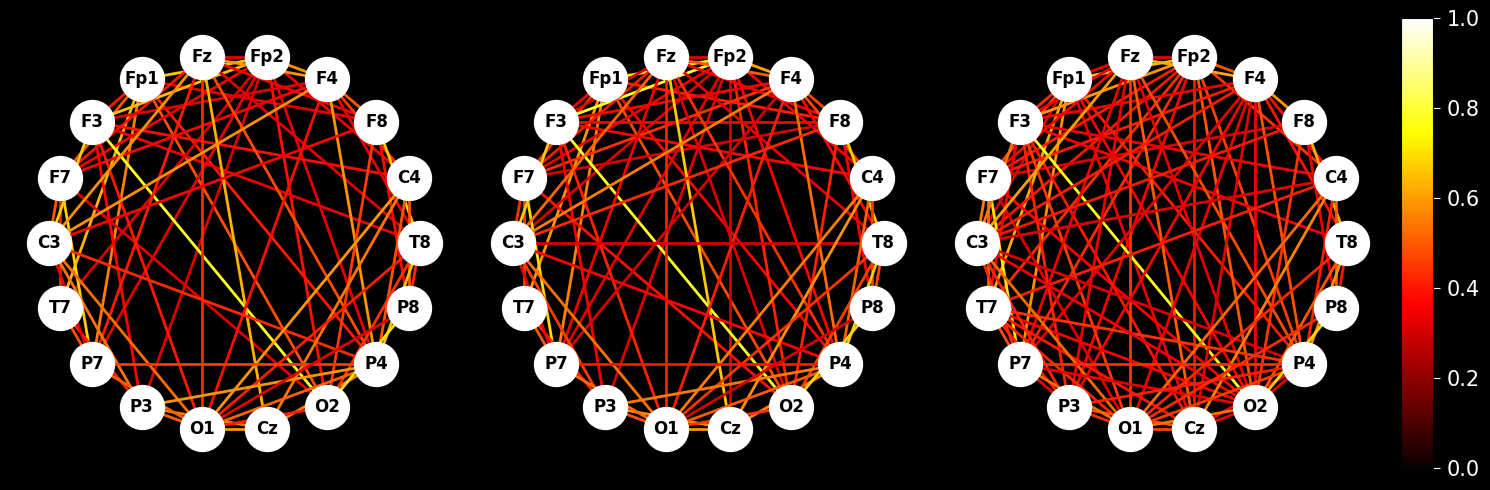

In [21]:
custom_labels = {n : ch_names_current[n] for n in range(len(ch_names_current))}
fig, axes = plt.subplots(ncols=4,nrows=1,figsize=(15,5),gridspec_kw={'width_ratios': [1, 1, 1, 0.07]})
axes = axes.ravel()
cmap = plt.cm.hot
for n,dict_att in enumerate(masks_list):
    torch_geometric.seed_everything(42)
    g = create_graph_from_dict(dict_att, threshold=0.3)
    edge_opacities = [
        strength
        for strength in nx.get_edge_attributes(g, "strength").values()
    ]
    pos_circular = nx.circular_layout(g)
    pos_custom = {n : pos_circular[channel_mapping[n]] for n in range(len(ch_names_current))}
    nx.draw(
        g,
        with_labels=True,
        labels=custom_labels,
        pos=pos_custom,
        font_weight="bold",
        edge_color=edge_opacities,
        width=2,
        node_size=1000,
        node_color="white",
        edge_cmap=cmap,
        ax=axes[n],
        edge_vmin=0,
        edge_vmax=1,
    )
    
cax = axes[-1]
# norm = matplotlib.colors.Normalize(vmin=0.2, vmax=1)
colorbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap),cax=cax,
)
color = "white"
# colorbar.set_label(label="Connection Strength", color=color, size=15)
# colorbar.ax.set_ylim([0.2,10])
colorbar.ax.yaxis.set_tick_params(color=color, labelcolor=color, size=5, labelrotation=00)
colorbar.ax.tick_params(axis='y', which='major', pad=5, labelsize=15)
fig = plt.gcf()
fig.set_facecolor("black")  # Set the background color here
fig.tight_layout()
fig.savefig(f"/home/szymon/code/sano/sano_eeg/plots/attention/conncectivity_{lookback}.pdf",dpi=400)
plt.show()

# Feature importances

## Load the computed feature importances

In [50]:
lookback = 3600
result_dir = f"../explainability_results/feature_importances/final_runs_lookback_{lookback}"
save_differences_path = f"../plots/feature_importances/feature_importance_diffs_{lookback}.pdf"
try:
    del sum_masks
except NameError:
    print("No sum masks")
try:
    del ictal_masks
except NameError:
    print("No ictal masks")
try:
    del interictal_masks
except NameError:
    print("No interictal masks")
try:
    del preictal_masks
except NameError:
    print("No preictal masks")
for n, fold_folder in enumerate(os.listdir(result_dir)):
    explanation_filenames = [os.path.join(result_dir, fold_folder, f) for f in os.listdir(os.path.join(result_dir, fold_folder)) if f.endswith(".pt")]
    explanation_filenames.sort()
 
    for explanation_filename in explanation_filenames:
        explanation = torch.load(explanation_filename)
        keyword = os.path.basename(explanation_filename).split('_')[-1].split('.')[0]
        if 'sum' == keyword:
            try:
                sum_masks += explanation.node_mask
            except NameError:
                print("Error")
                sum_masks = explanation.node_mask
        elif 'ictal' == keyword:
            try:
                ictal_masks += explanation.node_mask
            except NameError:
                print("Error")
                ictal_masks = explanation.node_mask
        elif 'interictal' == keyword:
            try:
                interictal_masks += explanation.node_mask
            except NameError:
                print("Error")
                interictal_masks = explanation.node_mask
        elif 'preictal' == keyword:
            try:
                preictal_masks += explanation.node_mask
            except NameError:
                print("Error")
                preictal_masks = explanation.node_mask

sum_masks /= len(explanation_filenames)
ictal_masks /= len(explanation_filenames)
interictal_masks /= len(explanation_filenames)
preictal_masks /= len(explanation_filenames)



Error
Error
Error
Error


In [51]:
sum_importances = sum_masks.sum(dim=0).numpy()
ictal_importances = ictal_masks.sum(dim=0).numpy()
interictal_importances = interictal_masks.sum(dim=0).numpy()
preictal_importances = preictal_masks.sum(dim=0).numpy()

# Visualize

In [52]:
def show_importances(scores, labels, ax):
    """Helper function to plot the feature importances.
    Args:
        scores (np.array): Array of feature importances.
        labels (list): List of feature names.
        ax (matplotlib.axes): Matplotlib axes object.
    """
    # Sort the scores and labels together while keeping the coherence
    fontsize = 12
    sorted_indices = np.argsort(scores)
    sorted_scores = scores[sorted_indices]
    sorted_labels = labels[sorted_indices]

    # Create the bar plot
    ax.barh(range(len(sorted_scores)), sorted_scores)
    ax.set_yticks(range(len(sorted_scores)), sorted_labels)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    

In [53]:
feature_labels = np.array(['Hjorth activity', 'Hjorth mobility','Hjorth complexity',
                "Line length", "Katz FD", "Higuchi FD", "Delta band energy",
                "Theta band energy", "Alpha band energy", "Beta band energy"
                ])

In [54]:
interictal_importances_dict = {feature_labels[i]: interictal_importances[i] for i in range(len(interictal_importances))}
ictal_importances_dict = {feature_labels[i]: ictal_importances[i] for i in range(len(ictal_importances))}
preictal_importances_dict = {feature_labels[i]: preictal_importances[i] for i in range(len(preictal_importances))}


In [55]:
def compare_feature_importances_dicts(feature_dict_1, feature_dict_2):
    """Helper function to compare two feature importance dictionaries.
    Args:
        feature_dict_1 (dict): First feature importance dictionary.
        feature_dict_2 (dict): Second feature importance dictionary.
    Returns:
        dict: Dictionary of features that are in both input dictionaries and their difference in importance.
    """
    
    return {k: abs(feature_dict_1[k] - feature_dict_2[k]) for k in feature_dict_1.keys()}

In [56]:
from matplotlib.patches import Patch
def compare_and_plot_parameter_differences(interictal_dict, preictal_dict, ictal_dict):
    """Helper function to compute the differences in feature importances between
    interictal and preictal states, preictal and icatal states and interictal and ictal states.
    Args:
        interictal_dict (dict): Dictionary of feature importances for interictal state.
        preictal_dict (dict): Dictionary of feature importances for preictal state.
        ictal_dict (dict): Dictionary of feature importances for ictal state.
    """
    interictal_preictal_diff = compare_feature_importances_dicts(interictal_dict, preictal_dict)
    interictal_ictal_diff = compare_feature_importances_dicts(interictal_dict, ictal_dict)
    preictal_ictal_diff = compare_feature_importances_dicts(preictal_dict, ictal_dict)

    fig, axes = plt.subplots(nrows=5,ncols=2, figsize=(5, 10))
    axes = axes.ravel()
    for i,feature in enumerate(interictal_dict.keys()):
        inter_pre_diff_key = interictal_preictal_diff[feature]
        inter_ict_diff_key = interictal_ictal_diff[feature]
        pre_ict_diff_key = preictal_ictal_diff[feature]
        diff_list = [inter_pre_diff_key, inter_ict_diff_key, pre_ict_diff_key]
        colors=["lightcoral", "royalblue", "yellowgreen"]
        axes[i].bar(range(len(diff_list)), diff_list, color=colors)
        xtick_list = ["Interictal - Preictal", "Interictal - Ictal", "Preictal - Ictal"]
        axes[i].set_xticks(range(len(diff_list)), '')
        axes[i].set_title(feature)
        legend_elements = [Patch(facecolor=color, label=label) for color, label in zip(colors, xtick_list)]
    
    plt.tight_layout()
    fig.legend(handles=legend_elements,loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=3)
    fig.savefig(save_differences_path, dpi=400, bbox_inches='tight')
    plt.show()
    

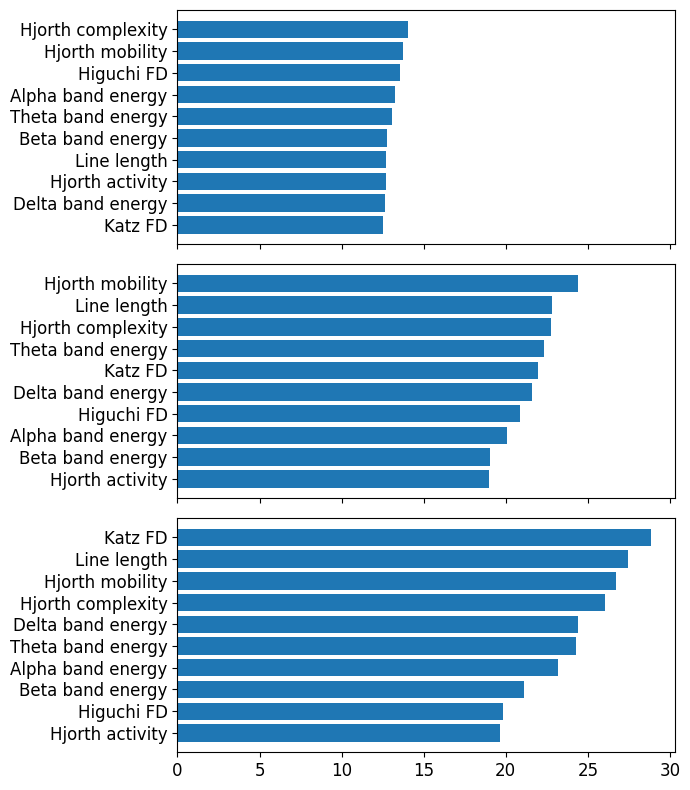

In [57]:

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 8),sharex=True)
show_importances(interictal_importances, feature_labels, axes[0])
show_importances(preictal_importances, feature_labels, axes[1])
show_importances(ictal_importances, feature_labels, axes[2])
plt.tight_layout()  # To avoid label cutoffs

fig.savefig(f"../plots/feature_importances/feature_importance_{lookback}.pdf",dpi=400)
plt.show()

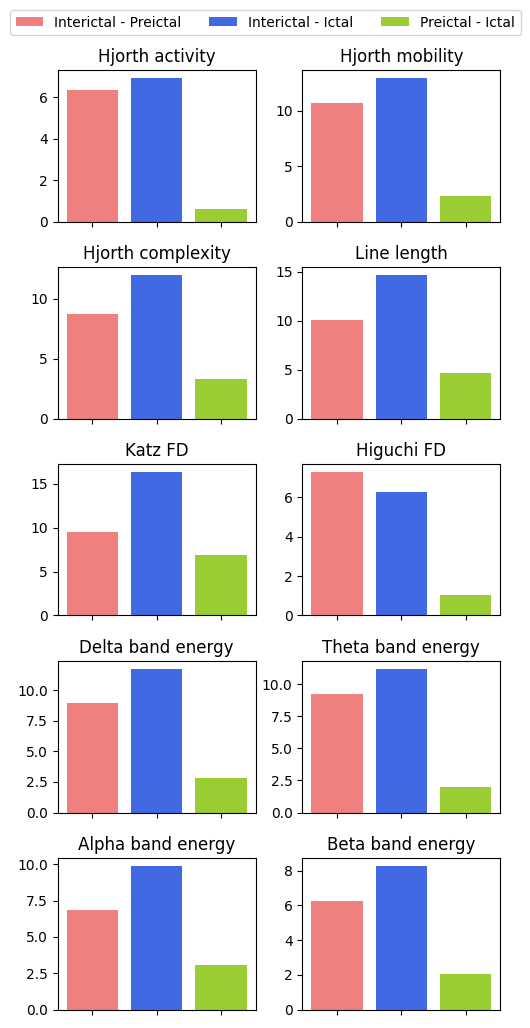

In [58]:
compare_and_plot_parameter_differences(interictal_importances_dict, preictal_importances_dict, ictal_importances_dict)


# Interictal predictions visulaization

In [ ]:
import json
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator


In [ ]:
lookback = 1200
json_file  = f'../explainability_results/predictive_horizon/final_runs_lookback_{lookback}/time_labels_acc.json'
save_file  = f'../plots/predictive_horizon/horizon_lookback_{lookback}.pdf'
save_raw_file = f'../plots/predictive_horizon/horizon_lookback_{lookback}_raw.pdf'
with open(json_file, 'r') as f:
    data = json.load(f)
time_labels, accuracies = zip(*data.items())
time_labels, accuracies = np.array(time_labels, dtype=np.int16), np.array(accuracies, dtype=np.float64)

In [ ]:
#plot raw
fig = plt.figure(figsize=(7, 5))
plt.plot(time_labels/60, accuracies*100, 'k')
plt.xlabel('Time to seizure (min)')
plt.ylabel('Preictal Accuracy (%)')
plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) 
plt.gca().yaxis.set_major_formatter(FuncFormatter('{:.0f}'.format))
plt.xlim(lookback/60, 0)
plt.savefig(save_raw_file,)

In [ ]:
def average_smooth_window(time_labels, accuracies, window_size):
    window_time_label_mean, window_accuracy_mean = [], []
    window_accuracy_sem = []
    for i in range(0,len(time_labels),window_size):
        window_time_label_mean.append(np.nanmean(np.where((time_labels>=i) & (time_labels<(i+window_size)), time_labels, np.nan)))
        window_accuracy_mean.append(np.nanmean(np.where((time_labels>=i) & (time_labels<(i+window_size)), accuracies, np.nan)))
        window_accuracy_sem.append(np.nanstd(np.where((time_labels>=i) & (time_labels<(i+window_size)), accuracies, np.nan))/np.sqrt(window_size))

    # Transform to percentages array
    window_time_label_mean, window_accuracy_mean = np.array(window_time_label_mean, dtype=np.float64)/60, np.array(window_accuracy_mean, dtype=np.float64)*100
    window_accuracy_sem = np.array(window_accuracy_sem, dtype=np.float64)*100
    return window_time_label_mean, window_accuracy_mean, window_accuracy_sem

# Plot
def plot_trend(window_time_label_mean, window_accuracy_mean, window_accuracy_sem, window_size):
    

    # Create a figure and a grid specification
    fig = plt.figure(figsize=(7, 5))
    gs = GridSpec(2, 1, height_ratios=[3, 2])  # 2 rows, first row has 1 unit height, second row has 1 unit height

    # Create the top subplot
    ax1 = plt.subplot(gs[0])
    ax1.plot(window_time_label_mean, window_accuracy_mean, 'k')
    ax1.fill_between(window_time_label_mean, window_accuracy_mean-window_accuracy_sem, window_accuracy_mean+window_accuracy_sem, facecolor="black", alpha=0.3)
    
    ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax1.spines['bottom'].set_visible(False), ax1.spines['right'].set_visible(False), ax1.spines['top'].set_visible(False)
    ax1.set_ylabel("Preictal accuracy (%)", fontsize=12)
    ax1.invert_xaxis()
    # ax1.yaxis.set_major_formatter(FuncFormatter('{:.0f}'.format))
    ax1.xaxis.set_major_formatter(FuncFormatter('{:.0f}'.format))
    # ax1.yaxis.set_major_locator(MaxNLocator(integer=True))

    # ax1.set_title(f"Window size of {window_size} seconds", fontweight="bold")

    # Create the bottom subplot and share the x-axis with the top one
    ax2 = plt.subplot(gs[1], sharex=ax1)
    ax2.plot(window_time_label_mean, window_accuracy_sem, 'k')
    ax2.spines['right'].set_visible(False), ax2.spines['top'].set_visible(False)
    #ax2.set_xlim([0,60])
    ax2.set_ylabel("SEM accuracy (%)", fontsize=12)
    ax2.set_xlabel("Time to seizure (min)", fontsize=12)
    ax2.yaxis.set_major_formatter(FuncFormatter('{:.2f}'.format))
    plt.xlim([lookback/60,0])
    plt.tight_layout()
    #plt.savefig(f"Accuracy-trend_WS-{window_size}.svg", format='svg', dpi=500)
    #plt.close()

def average_smooth_window(time_labels, accuracies, window_size):
    window_time_label_mean, window_accuracy_mean = [], []
    window_accuracy_sem = []
    for i in range(0,len(time_labels),window_size):
        window_time_label_mean.append(np.nanmean(np.where((time_labels>=i) & (time_labels<(i+window_size)), time_labels, np.nan)))
        window_accuracy_mean.append(np.nanmean(np.where((time_labels>=i) & (time_labels<(i+window_size)), accuracies, np.nan)))
        window_accuracy_sem.append(np.nanstd(np.where((time_labels>=i) & (time_labels<(i+window_size)), accuracies, np.nan))/np.sqrt(window_size))

    # Transform to percentages array
    window_time_label_mean, window_accuracy_mean = np.array(window_time_label_mean, dtype=np.float64)/60, np.array(window_accuracy_mean, dtype=np.float64)*100
    window_accuracy_sem = np.array(window_accuracy_sem, dtype=np.float64)*100
    return window_time_label_mean, window_accuracy_mean, window_accuracy_sem



In [ ]:
window_size = 60
window_time_label_mean, window_accuracy_mean, window_accuracy_sem = average_smooth_window(time_labels, accuracies, window_size)
plot_trend(window_time_label_mean, window_accuracy_mean, window_accuracy_sem, window_size)
plt.savefig(save_file, format='pdf', dpi=500)